In [ ]:
from pathlib import Path
import random
import pandas as pd

import numpy as np

import tifffile
from tifffile import TiffFile
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch

import plotly.express as px

import re 


In [2]:
test_labels = pd.read_csv('../data/test_images_kkwOpBC.csv', sep = ',')
test_infos = pd.read_csv('../data/test_predicted_random_rp2A5Fo.csv', sep = ',')
train_labels = pd.read_csv('../data/train_images_Es8kvkp.csv', sep = ',')
train_infos = pd.read_csv('../data/train_labels_GY1QjFw.csv', sep = ',')

In [3]:
train_infos

,sample_id,no_data,clouds,artificial,cultivated,broadleaf,coniferous,herbaceous,natural,snow,water
0,1,0.0,0.0,0.032867,0.743835,0.054214,0.000565,0.168518,0.0,0.0,0.000000
1,2,0.0,0.0,0.094040,0.759445,0.025238,0.000320,0.120544,0.0,0.0,0.000412
2,3,0.0,0.0,0.043762,0.575974,0.061676,0.001053,0.317535,0.0,0.0,0.000000
3,4,0.0,0.0,0.007538,0.116974,0.448486,0.042938,0.382553,0.0,0.0,0.001511
4,5,0.0,0.0,0.022217,0.279907,0.414169,0.013840,0.268982,0.0,0.0,0.000885
...,...,...,...,...,...,...,...,...,...,...,...
18486,23530,0.0,0.0,0.012085,0.338425,0.306961,0.163940,0.178558,0.0,0.0,0.000031
18487,23531,0.0,0.0,0.011215,0.339767,0.389206,0.068848,0.190964,0.0,0.0,0.000000
18488,23532,0.0,0.0,0.004700,0.397827,0.395844,0.040085,0.161545,0.0,0.0,0.000000
18489,23533,0.0,0.0,0.006180,0.391693,0.481750,0.027878,0.092499,0.0,0.0,0.000000


### Analyse  
Les **test_labels** correspondent aux ID de **test_infos**.  
Ainsi, le premier élément de **test_labels** est déjà présent dans **test_infos**.  

### Conclusion  
Il n'est donc **pas nécessaire** de conserver **test_labels** séparément.  
Même raisonnement pour **train**.  

**Optimisation possible** : Éviter la redondance des données afin d'améliorer l'efficacité du traitement.  


In [ ]:

DATASET_FOLDER = Path('../dataset')

def extract_number(file_path):
    """
    Cette fonction permet d'extraire le numéro d'une image à partir de son chemin.
    """
    match = re.search(r'(\d+)', file_path.name) # On récfupère ici les numéros potentiellement présents dans le nom du fichier
    return int(match.group(1)) if match else 0 # On les récupère et transforme en entier si ils existent, sinon on retourne 0

# Pour chaque ensemble, on trie tout les fichiers selon leurs  numéros
train_images_paths = sorted(list(DATASET_FOLDER.glob('train/images/*.tif')), key=extract_number)
train_masks_paths = sorted(list(DATASET_FOLDER.glob('train/masks/*.tif')), key=extract_number)
test_images_paths = sorted(list(DATASET_FOLDER.glob('test/images/*.tif')), key=extract_number)


CLASSES = [
    'no_data',
    'clouds',
    'artificial',
    'cultivated',
    'broadleaf',
    'coniferous',
    'herbaceous',
    'natural',
    'snow',
    'water'
]

# Palette de couleurs pour affichage des masques
CLASSES_COLORPALETTE = {
    0: [0, 0, 0],        # no_data (noir)
    1: [255, 25, 236],   # clouds (rose)
    2: [215, 25, 28],    # artificial (rouge)
    3: [211, 154, 92],   # cultivated (marron clair)
    4: [33, 115, 55],    # broadleaf (vert foncé)
    5: [21, 75, 35],     # coniferous (vert plus foncé)
    6: [118, 209, 93],   # herbaceous (vert clair)
    7: [130, 130, 130],  # natural (gris)
    8: [255, 255, 255],  # snow (blanc)
    9: [43, 61, 255]     # water (bleu)
}

CLASSES_COLORPALETTE = {c: np.asarray(color) / 255. for (c, color) in CLASSES_COLORPALETTE.items()}


In [5]:
def show_image(image, display_min=50, display_max=400, ax=None):
    """Show an image.
    Args:
        image (numpy.array[uint16]): the image. If the image is 16-bit, apply bytescaling to convert to 8-bit
    """
    if image.dtype == np.uint16:
        iscale = display_max - display_min
        scale = 255 / iscale
        byte_im = (image) * scale
        byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
        image = byte_im
    # show image
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(image)
    return im

def show_mask(mask, classes_colorpalette, classes=None, add_legend=True, ax=None):
    """Show a a semantic segmentation mask.
    Args:
       mask (numpy.array[uint8]): the mask in 8-bit
       classes_colorpalette (dict[int, tuple]): dict mapping class index to an RGB color in [0, 1]
       classes (list[str], optional): list of class labels
       add_legend
    """
    show_mask = np.empty((*mask.shape, 3))
    for c, color in classes_colorpalette.items():
        show_mask[mask == c, :] = color
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(show_mask)
    if add_legend:
        import matplotlib.patches as mpatches
        handles = []
        for c, color in classes_colorpalette.items():
            handles.append(mpatches.Patch(color=color, label=classes[c]))
        ax.legend(handles=handles)
    return im

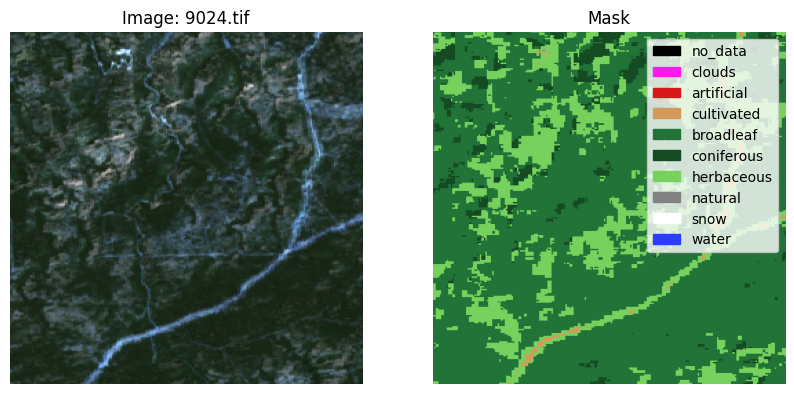

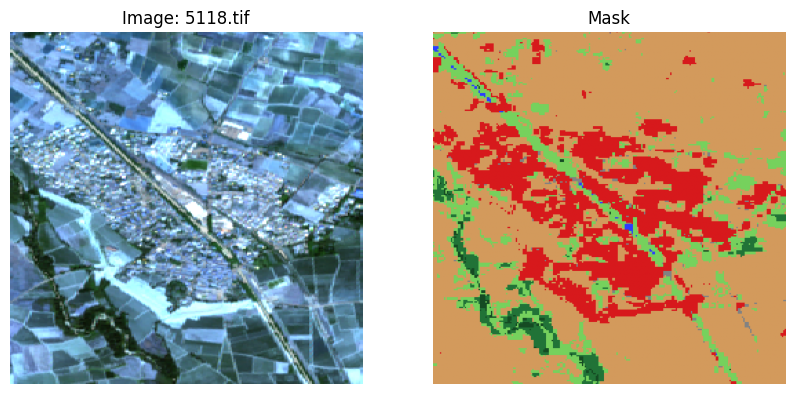

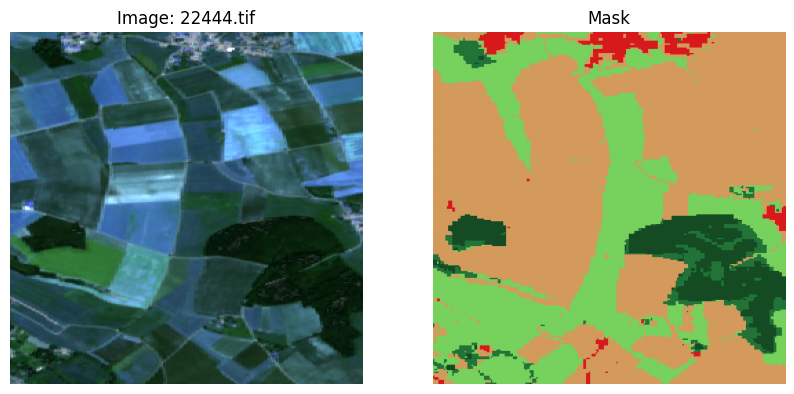

In [6]:
for k, idx in enumerate(random.sample(range(len(train_images_paths)), 3)):
    image_path = train_images_paths[idx]
    mask_path = train_masks_paths[idx]
    assert image_path.name == mask_path.name
    
    with TiffFile(image_path) as tif:
        arr = tif.asarray()        
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    show_image(arr, display_min=0, display_max=2200, ax=axs[0])
    
    with TiffFile(mask_path) as tif:
        arr = tif.asarray()
    classes_colorpalette = CLASSES_COLORPALETTE

    show_mask(arr,
              classes_colorpalette = classes_colorpalette,
              classes = CLASSES,
              add_legend=(k == 0),
              ax=axs[1]
    )
    axs[0].set_title(f'Image: {image_path.name}')
    axs[1].set_title('Mask')
    #fig.tight_layout()

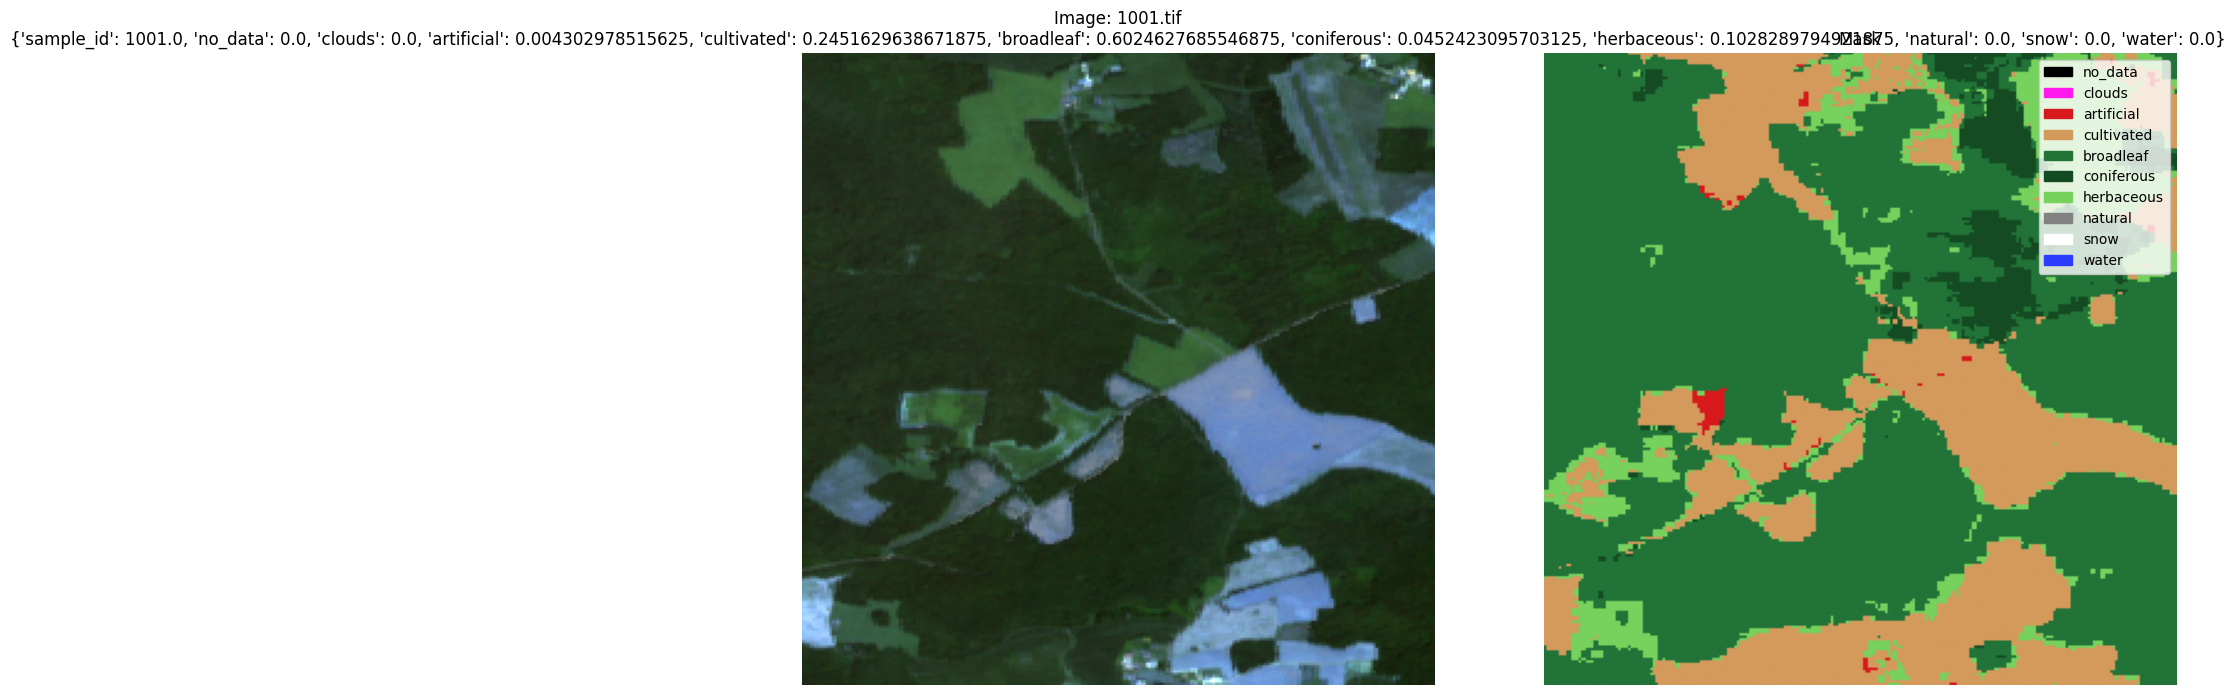

In [7]:
idx = 1000 

image_path = train_images_paths[idx]
mask_path = train_masks_paths[idx]
assert image_path.name == mask_path.name

with TiffFile(image_path) as tif:
    image_arr = tif.asarray()

with TiffFile(mask_path) as tif:
    mask_arr = tif.asarray()

image_info = train_infos.iloc[idx]

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

show_image(image_arr, display_min=0, display_max=2200, ax=axs[0])
axs[0].set_title(f"Image: {image_path.name}\n{image_info.to_dict()}")

classes_colorpalette = CLASSES_COLORPALETTE  
show_mask(mask_arr,
          classes_colorpalette=classes_colorpalette,
          classes=CLASSES,
          add_legend=True,  
          ax=axs[1]
)
axs[1].set_title('Mask')

plt.tight_layout()
plt.show()


In [ ]:
cols_to_keep = train_infos.columns.difference(['sample_id', 'no_data', 'clouds'])

# Calculer la somme des pourcentages pour chaque classe
class_distribution = train_infos[cols_to_keep].sum()
print(class_distribution)
# Convertir en DataFrame pour utilisation avec Plotly
df_plot = pd.DataFrame({"Classe": class_distribution.index, "Total Pourcentage": class_distribution.values})

# Création du graphique interactif
fig = px.bar(df_plot, 
             x="Classe", 
             y="Total Pourcentage", 
             title="Répartition des classes sur l’ensemble des images",
             labels={"Total Pourcentage": "Total des pourcentages", "Classe": "Classes"},
             text_auto=True,
             color="Classe")

# Afficher le graphique
fig.show()


artificial     930.344009
broadleaf     4226.873428
coniferous    1472.061859
cultivated    6176.162430
herbaceous    5087.389114
natural        149.159164
snow             0.016342
water          448.678665
dtype: float64


# Transformation en Tenseurs des images

In [44]:
from PIL import Image
from torchvision import transforms
img_path = '../dataset/train/images/1.tif'


# Checking the format of my images
with TiffFile(img_path) as tif:
    image_arr = tif.asarray()

image_arr.shape
image_arr[0]


array([[ 687, 1043, 1527, 2678],
       [ 686, 1042, 1542, 2653],
       [ 718, 1086, 1581, 2700],
       ...,
       [ 949, 1002, 1162, 1338],
       [ 611,  698,  800, 2182],
       [ 611,  698,  800, 2182]], dtype=uint16)

In [ ]:
list_of_tensors = []

for path in train_images_paths: # On viens chercher tout les chemins de nos images
    img_matrix = tifffile.imread(path) # On charge l'image
    tensor_img = torch.tensor(img_matrix, dtype=torch.float32) / 65535.0 # On transforme l'image en tenseur tout en 
    # la normalisant, étant donné que les images sont en 16 bits, on divise par 65535 pour obtenir des valeurs entre 0 et 1
    tensor_img = tensor_img.permute(2, 0, 1) # On permute les dimensions pour obtenir un format attendu par PyTorch
    list_of_tensors.append(tensor_img) # On ajoute le tenseur à notre liste

torch.save(list_of_tensors, 'all_tensors.pt') # On sauvegarde la liste de tenseurs de côté
print(tensor_img.shape)

torch.Size([4, 256, 256])
